<a href="https://colab.research.google.com/github/Leonid393/projects/blob/main/sklearn_oil_bss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import mean_squared_error

In [ ]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [ ]:
display(df1.info())
display(df1.head())
display(df2.info())
display(df2.head())
display(df3.info())
display(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Имеем три датасета по данным геологоразведки с ID, параметрами f0, f1, f2 и целевым признаком product. Датафреймы не имеют пропусков и некорректных типов данных по столбцам. Все ок.

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


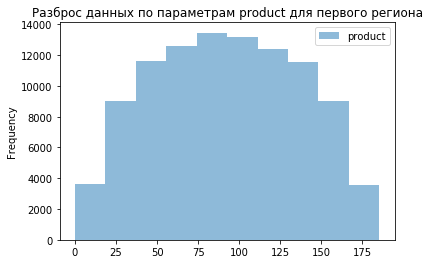

In [ ]:
display(df1.describe())
df1.plot(y='product', kind='hist', alpha = 0.5, title = 'Разброс данных по параметрам product для первого региона')
plt.show()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


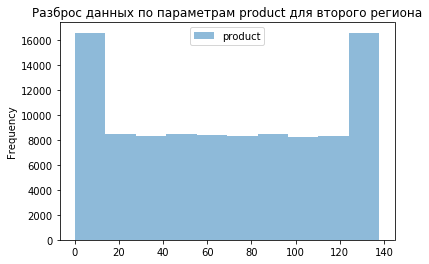

In [ ]:
display(df2.describe())
df2.plot(y='product', kind='hist', alpha = 0.5, title = 'Разброс данных по параметрам product для второго региона')
plt.show()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


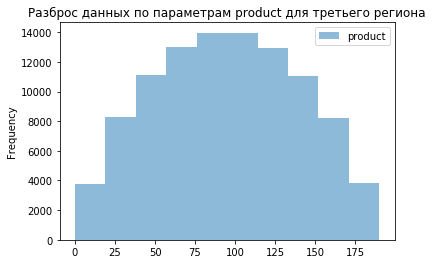

In [ ]:
display(df3.describe())
df3.plot(y='product', kind='hist', alpha = 0.5, title = 'Разброс данных по параметрам product для третьего региона')
plt.show()

По признаку f2 разброс значений во всех трех датафреймах значительно отличается от соответствующих признаков f0 и f1.<br> Анализируем данные на наличие выбросов только по параметру 'product', поскольку по вводным параметрам признаки f0,f1,f2 не значимы для дальнейшей оценки.<br>

In [ ]:
Q1_1 =  df1['product'].quantile(0.25)
Q3_1 = df1['product'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
df1_clean = df1.query('@Q1_1 - 1.5*@IQR_1 < product < @Q3_1 + 1.5*@IQR_1')
print('Количество выбросов по первому региону - ', (len(df1_clean)-len(df1)))

Количество выбросов по первому региону -  0


In [ ]:
Q1_2 =  df2['product'].quantile(0.25)
Q3_2 = df2['product'].quantile(0.75)
IQR_2 = Q3_2 - Q1_2
df2_clean = df2.query('@Q1_2 - 1.5*@IQR_2 < product < @Q3_2 + 1.5*@IQR_2')
print('Количество выбросов по второму региону - ', len(df2_clean)-len(df2))

Количество выбросов по второму региону -  0


In [ ]:
Q1_3 =  df3['product'].quantile(0.25)
Q3_3 = df3['product'].quantile(0.75)
IQR_3 = Q3_3 - Q1_3
df3_clean = df3.query('@Q1_3 - 1.5*@IQR_3 < product < @Q3_3 + 1.5*@IQR_3')
print('Количество выбросов по третьему региону - ', len(df3_clean)-len(df3))

Количество выбросов по третьему региону -  0


Подсчитал количество выбросов по параметру product, как и примерно казалось из данных таблицы describe, выбросы отсутствуют.

In [ ]:
df1_doubl = df1.drop_duplicates()
print(df1_doubl.shape)

df2_doubl = df2.drop_duplicates()
print(df2_doubl.shape)

df3_doubl = df3.drop_duplicates()
print(df3_doubl.shape)

(100000, 5)
(100000, 5)
(100000, 5)


Дубликатов так же нет

## Обучение и проверка модели

### Разбивка на обучающую и валидационные выборки

In [ ]:
target_1 = df1['product']
features_1 = df1.drop(['id', 'product'], axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

print('Размер обучающей выборки - {:.0%}'.format(len(target_train_1)/len(df1)))
print('Размер валидационной выборки - {:.0%}'.format(len(target_valid_1)/len(df1)))

Размер обучающей выборки - 75%
Размер валидационной выборки - 25%


In [ ]:
target_2 = df2['product']
features_2 = df2.drop(['id', 'product'], axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

print('Размер обучающей выборки - {:.0%}'.format(len(target_train_2)/len(df2)))
print('Размер валидационной выборки - {:.0%}'.format(len(target_valid_2)/len(df2)))

Размер обучающей выборки - 75%
Размер валидационной выборки - 25%


In [ ]:
target_3 = df3['product']
features_3 = df3.drop(['id', 'product'], axis=1)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=12345)

print('Размер обучающей выборки - {:.0%}'.format(len(target_train_3)/len(df3)))
print('Размер валидационной выборки - {:.0%}'.format(len(target_valid_3)/len(df3)))

Размер обучающей выборки - 75%
Размер валидационной выборки - 25%


Масштабируем значения признаков

In [ ]:
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1)
features_train_1 = scaler_1.transform(features_train_1)
features_valid_1 = scaler_1.transform(features_valid_1)
display(pd.DataFrame(features_valid_1).describe())

,0,1,2
count,25000.000000,25000.000000,25000.000000
mean,0.013667,0.000629,-0.004025
std,0.999992,1.001848,0.998251
min,-2.064269,-2.096946,-4.491004
25%,-0.645001,-0.897958,-0.692080
50%,0.014689,0.002940,-0.000191
75%,0.673651,0.895259,0.671019
max,2.067368,2.144367,3.849118


In [ ]:
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2)
features_train_2 = scaler_2.transform(features_train_2)
features_valid_2 = scaler_2.transform(features_valid_2)
display(pd.DataFrame(features_valid_2).describe())

,0,1,2
count,25000.000000,25000.000000,25000.000000
mean,0.000633,-0.003662,-0.002833
std,1.000147,0.994468,1.002369
min,-2.886396,-3.998414,-1.476266
25%,-0.833219,-0.681979,-0.878589
50%,0.000957,-0.012260,-0.285396
75%,0.832089,0.668601,0.883444
max,2.832540,4.199206,1.482087


In [ ]:
scaler_3 = StandardScaler()
scaler_3.fit(features_train_3)
features_train_3 = scaler_3.transform(features_train_3)
features_valid_3 = scaler_3.transform(features_valid_3)
display(pd.DataFrame(features_valid_3).describe())

,0,1,2
count,25000.000000,25000.000000,25000.000000
mean,-0.005684,0.006928,-0.003670
std,1.000075,0.997780,1.001740
min,-4.153552,-3.894765,-3.930552
25%,-0.679216,-0.667033,-0.688796
50%,-0.000986,0.004229,-0.000954
75%,0.668079,0.675134,0.678608
max,3.603782,3.944356,3.577696


### Обучение моделей

In [ ]:
#model_1 = LinearRegression()
#model_1.fit(features_train_1, target_train_1)

In [ ]:
#model_2 = LinearRegression()
#model_2.fit(features_train_2, target_train_2)

In [ ]:
#model_3 = LinearRegression()
#model_3.fit(features_train_3, target_train_3)

### Предсказания моделей

In [ ]:
#predictions_1 = model_1.predict(features_valid_1)

In [ ]:
#predictions_2 = model_2.predict(features_valid_2)

In [ ]:
#predictions_3 = model_3.predict(features_valid_3)

### Средний запас предсказанного сырья и RMSE моделей

In [ ]:
#print('Средний запас предсказанного сырья для первого регоина - {:.0F}'.format(predictions_1.mean()), 'тыс. баррелей')
#print('Средний запас предсказанного сырья для первого регоина - {:.0F}'.format(predictions_2.mean()), 'тыс. баррелей')
#print('Средний запас предсказанного сырья для первого регоина - {:.0F}'.format(predictions_3.mean()), 'тыс. баррелей')

In [ ]:
#print("RMSE первой модели - {:.0f}".format(mean_squared_error(target_valid_1, predictions_1)**0.5))
#print("RMSE второй модели - {:.0f}".format(mean_squared_error(target_valid_2, predictions_2)**0.5))
#print("RMSE третьей модели - {:.0f}".format(mean_squared_error(target_valid_3, predictions_3)**0.5))

### Анализ результатов

Значения RMSE моделей можно интерпретировать как вывод о том, что в первом и третьем регионе значения product больше чем во втором и при попытке их предсказать получается бОльший разброс. О чем косвенно можно судить по величине среднего значения запасов сырья.

In [ ]:
def make_model(features_train, target_train, features_valid, target_valid, number):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('Средний запас предсказанного сырья для ', number,' регоина - {:.0F}'.format(predictions.mean()), 'тыс. баррелей')
    print('RMSE ', number,' модели - {:.0f}'.format(mean_squared_error(target_valid, predictions)**0.5))
    return model, predictions

In [ ]:
model_1, predictions_1 = make_model(features_train_1, target_train_1, features_valid_1, target_valid_1, 1)
model_2, predictions_2 = make_model(features_train_2, target_train_2, features_valid_2, target_valid_2, 2)
model_3, predictions_3 = make_model(features_train_3, target_train_3, features_valid_3, target_valid_3, 3)

Средний запас предсказанного сырья для  1  регоина - 93 тыс. баррелей
RMSE  1  модели - 38
Средний запас предсказанного сырья для  2  регоина - 69 тыс. баррелей
RMSE  2  модели - 1
Средний запас предсказанного сырья для  3  регоина - 95 тыс. баррелей
RMSE  3  модели - 40


## Подготовка к расчёту прибыли

### Расчет ключевых значений

In [ ]:
REG_DRILL_DEV = 10_000_000
BAR_PRICE = 450
BOREHOLE_COUNT = 200

### Расчет объема для безубыточной разработки новой скважины

In [ ]:
min_product_per_1 = (REG_DRILL_DEV / BAR_PRICE) / BOREHOLE_COUNT
print('Минимальное значение объема запасов на одну скважину - {:.2F}'.format(min_product_per_1))
print('Среднее значение запасов по первому региону - {:.2f}'.format(df1['product'].mean()))
print('Среднее значение запасов по второму региону - {:.2f}'.format(df2['product'].mean()))
print('Среднее значение запасов по третьему региону - {:.2f}'.format(df3['product'].mean()))

Минимальное значение объема запасов на одну скважину - 111.11
Среднее значение запасов по первому региону - 92.50
Среднее значение запасов по второму региону - 68.83
Среднее значение запасов по третьему региону - 95.00


### Выводы

Среднее значение запасов по всем трем регионам ниже требуемого, что означает только то что не надо все 10000 скважин в регионе разрабатывать.

## Расчёт прибыли и рисков 

### Выбор скважин с наилучшим запасом по регионам

Если я правильно понял условие задачи - то необходимо предсказать данные в целом по региону используя созданные модели.

In [ ]:
#reg_1_predictions = model_1.predict(features_valid_1)
#reg_2_predictions = model_2.predict(features_valid_2)
#reg_3_predictions = model_3.predict(features_valid_3)

#reg_1_predictions = pd.DataFrame(reg_1_predictions)
#reg_1_predictions.columns = ['product']
#
#reg_2_predictions = pd.DataFrame(reg_2_predictions)
#reg_2_predictions.columns = ['product']

#reg_3_predictions = pd.DataFrame(reg_3_predictions)
#reg_3_predictions.columns = ['product']

Выбираем топ 200 лучших

In [ ]:
#reg_1_predictions_top200 = reg_1_predictions.sort_values(by='product', ascending = False).head(200)
#reg_2_predictions_top200 = reg_2_predictions.sort_values(by='product', ascending = False).head(200)
#reg_3_predictions_top200 = reg_3_predictions.sort_values(by='product', ascending = False).head(200)

In [ ]:
def join_targ_pred(target, predictions):
    target = pd.DataFrame(target)
    target = target.reset_index()
    predictions = pd.DataFrame(predictions).reset_index()
    predictions.columns = ['index','predicted']
    target['predicted'] = predictions['predicted']
    return target

In [ ]:
#    features = shuffle(features, random_state=12345)
#    features = pd.DataFrame(features).head(500)
#    reg_predictions = model.predict(features)
#    reg_predictions = pd.DataFrame(reg_predictions)
#    reg_predictions.columns = ['product']
#    reg_predictions_top200 = reg_predictions.sort_values(by='product', ascending = False).head(200)
#    return reg_predictions_top200

In [ ]:
reg_1_predictions = join_targ_pred(target_valid_1, predictions_1)
reg_2_predictions = join_targ_pred(target_valid_2, predictions_2)
reg_3_predictions = join_targ_pred(target_valid_3, predictions_3)

In [ ]:
#target_valid_1 = pd.DataFrame(target_valid_1)
#target_valid_1 = target_valid_1.reset_index()
#target_valid_1.head()
#predictions_1 = pd.DataFrame(predictions_1).reset_index()
#predictions_1.columns = ['index','predicted']
#predictions_1.head()

In [ ]:
#target_valid_1['predicted'] = predictions_1['predicted']
#target_valid_1.head(100)

In [ ]:
def profit_calc_top200(df):
    df = df.sort_values(by='predicted',ascending = False).head(200)
    total_revenue = (df['product'].sum() * BAR_PRICE * 1_000) / 1_000_000_000 - REG_DRILL_DEV / 1_000_000
    return total_revenue

In [ ]:
reg_1_profit = profit_calc_top200(reg_1_predictions)
reg_2_profit = profit_calc_top200(reg_2_predictions)
reg_3_profit = profit_calc_top200(reg_3_predictions)

print('Выручка 200 лучших скважин по первому региону - {:.2F}'.format(reg_1_profit), 'млрд.руб.')
print('Выручка 200 лучших скважин по второму региону - {:.2F}'.format(reg_2_profit), 'млрд.руб.')
print('Выручка 200 лучших скважин по третьему региону - {:.2F}'.format(reg_3_profit), 'млрд.руб.')

Выручка 200 лучших скважин по первому региону - 3.32 млрд.руб.
Выручка 200 лучших скважин по второму региону - 2.42 млрд.руб.
Выручка 200 лучших скважин по третьему региону - 2.71 млрд.руб.


## Расчет рисков и прибыли для каждого региона

In [ ]:
#state = np.random.RandomState(12345)
#values_1 = []

#for i in range(1000):
#    prob_subsample = reg_1_predictions_top200.sample(n=200, replace=True, random_state=state)
#    values_1.append(profit_calc(prob_subsample))

#values_1 = pd.Series(values_1)
#print("Средняя прибыль по первому региону - {:.2F}".format(values_1.mean()), 'млрд.руб')
#print("95%-ый доверительный интервал для первого региона:", st.t.interval(0.95, len(values_1)-1, values_1.mean(), values_1.sem()))

In [ ]:
#values_1=pd.DataFrame(values_1)
#values_1.columns = ['profit']

In [ ]:
#risk = values_1.query('profit < 0')

#print("Риск убытков первого региона - {:.0%}".format(len(risk)/len(values_1)))

In [ ]:
#print(stats.percentileofscore(values_1, 0))

In [ ]:
#values_2 = []
#for i in range(1000):
#    prob_subsample = reg_2_predictions_top200.sample(n=200, replace=True, random_state=state)
#    values_2.append(profit_calc(prob_subsample))
#values_2 = pd.Series(values_2)
#print("Средняя прибыль по второму региону - {:.2F}".format(values_2.mean()), 'млрд.руб')
#print("95%-ый доверительный интервал для второго региона:", st.t.interval(0.95, len(values_2)-1, values_2.mean(), values_2.sem()))

In [ ]:
#values_2=pd.DataFrame(values_2)
#values_2.columns = ['profit']

In [ ]:
#risk = values_2.query('profit < 0')

#print("Риск убытков второго региона - {:.0%}".format(len(risk)/len(values_1)))

In [ ]:
#values_3 = []
#for i in range(1000):
#    prob_subsample = reg_3_predictions_top200.sample(n=200, replace=True, random_state=state)
#    values_3.append(profit_calc(prob_subsample))
#values_3 = pd.Series(values_3)
#print("Средняя прибыль по третьему региону - {:.2F}".format(values_3.mean()), 'млрд.руб')
#print("95%-ый доверительный интервал для второго региона:", st.t.interval(0.95, len(values_3)-1, values_3.mean(), values_3.sem()))

In [ ]:
#values_3=pd.DataFrame(values_3)
#values_3.columns = ['profit']

In [ ]:
#risk = values_3.query('profit < 0')

#print("Риск убытков третьего региона - {:.0%}".format(len(risk)/len(values_1)))

In [ ]:
state = np.random.RandomState(12345)
def risk_and_profit(predictions, target, number_of_reg):
    values = []
    target = join_targ_pred(target, predictions)
    for i in range(1000):
        prob_subsample = target.sample(n=500, replace=True, random_state=state)
        values.append(profit_calc_top200(prob_subsample))
    values = pd.Series(values)
    print("Средняя прибыль по ",number_of_reg," региону - {:.2F}".format(values.mean()), 'млрд.руб')
    print("95%-ый доверительный интервал для ",number_of_reg," региона:", values.quantile(0.025), values.quantile(0.975))
    print("Риск убытков ",number_of_reg, " региона - {:.0F}".format(stats.percentileofscore(values, 0)),"%")
    print()

In [ ]:
risk_and_profit(predictions_1, target_valid_1, 1)
risk_and_profit(predictions_2, target_valid_2, 2)
risk_and_profit(predictions_3, target_valid_3, 3)

Средняя прибыль по  1  региону - 0.40 млрд.руб
95%-ый доверительный интервал для  1  региона: -0.11121554589049457 0.9097669415534217
Риск убытков  1  региона - 7 %

Средняя прибыль по  2  региону - 0.46 млрд.руб
95%-ый доверительный интервал для  2  региона: 0.07805081075174197 0.862952060263723
Риск убытков  2  региона - 1 %

Средняя прибыль по  3  региону - 0.39 млрд.руб
95%-ый доверительный интервал для  3  региона: -0.11222762537857499 0.9345629145511639
Риск убытков  3  региона - 6 %



## Вывод

В задании даны три датафрейма без пропусков и ошибок в типах данных. По столбцу product распределение значений соответствует нормальному и не имеет выбросов. По признакам f0,f1,f2 существует разброс данных, который подтвергся масштабированию. <br>
По значению RMSE можно сделать вывод, что чем больше сами значения целевого признака тем выше значение ошибки. <br>

Отвечая на поставленный вопрос по выбору региона: Хотя и при выборке топ200 лучших скважин побеждают первый и третий регион, все же рекомендуется выбрать именно второй регион для разработки. Т.к. мы имеем более точную модель и самое высокое значение средней выручке при бутстрэпе в 1000 раз.